### References

## Fashion-MNIST Classification

> Can we develop a model that has good performance on the Fashion-MNIST dataset?

### Context
Fashion-MNIST is a dataset from Zalando research, comprising of <code>28 x 28</code> grayscale images of a total fo <code>70000</code> fashion products from 10 categories. The intent of this dataset is to serve as a replacement for the MNIST dataset for testing and benchmarking machine learning and deep learning models (Xiao, Rasul and Vollgraf, 2017).

The dataset is based on images from Zalando's assortment. Each original image of <code>762 x 1000</code> in JPEG format was converted to PNG, resized, and then converted to grayscale.

### Objectives
<ol>
	<li>To explore and understand the dataset</li>
	<li>Understand the effects of different data augmentation techniques on the performance of the model</li>
	<li>Develop and experiment with models to rival state-of-the-art (SOTA) benchmark scores</li>
</ol>

## Importing libraries

In [29]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow

## Dataset
Let's take a look at the dataset. This dataset was retrieved from the original Fashion MNIST dataset found at <a href="https://arxiv.org/pdf/1708.07747v2.pdf">Paper Link</a>. We'll only be looking at training dataset to <strong>prevent data leakage</strong>.

In [6]:
train = pd.read_csv('data/fashion-mnist_train.csv')

In [35]:
arr = np.array(train.loc[5].drop('label'))

In [36]:
root = int(len(arr) ** 0.5)
arr.resize((root, root))

28


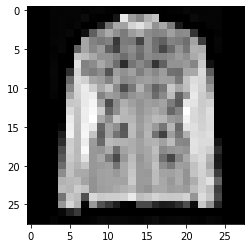

In [38]:
plt.imshow(arr, cmap='gray')